# Training a simple neural network to predict next day prices

## Setup

```bash
python3 -m venv .env
source .env/bin/activate
pip install -r requirements.txt
pip freeze > requirements.txt
```

Select the environment in Jupyter Notebook.

In [52]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

API_KEY = 'JY46FF8BN6CNDH5Z'

In [53]:
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter

# Limit yfinance requests to 2 per 5 seconds
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)

In [54]:
# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())

  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                   Biotechnology   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


In [55]:
stocks = tickers['Symbol'].tolist()
print(len(stocks))
stocks[:5]

503


['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [62]:
df_list = []
retrys = 0
for stock in stocks[:5]:
    while True:
        if retrys > 3:
            retrys = 0
            break
        time.sleep(2)
        try:
            df = yf.download(stock, auto_adjust=True, session=session)
            df['ticker'] = stock  # Add ticker column
            print(f"Downloaded {stock}", df.shape)
            if df.shape[0] < 252:
                retrys += 1
                continue
            df_list.append(df)
            break
        except Exception as e:
            print(e)
            retrys += 1
            continue
        
data = pd.concat(df_list)

[*********************100%%**********************]  1 of 1 completed


Downloaded MMM (15759, 6)


[*********************100%%**********************]  1 of 1 completed


Downloaded AOS (10298, 6)


[*********************100%%**********************]  1 of 1 completed


Downloaded ABT (11194, 6)


[*********************100%%**********************]  1 of 1 completed


Downloaded ABBV (2921, 6)


[*********************100%%**********************]  1 of 1 completed

Downloaded ACN (5801, 6)


In [63]:
print(data.shape)
print(data.tail())

(45973, 6)
                  Open        High         Low       Close   Volume ticker
Date                                                                      
2024-08-05  311.609985  317.869995  310.230011  313.739990  3186500    ACN
2024-08-06  317.000000  322.660004  315.720001  318.679993  2284200    ACN
2024-08-07  319.950012  325.739990  317.929993  318.019989  2327700    ACN
2024-08-08  315.299988  319.510010  314.470001  315.880005  2213700    ACN
2024-08-09  316.200012  317.320007  313.220001  315.829987  1851300    ACN


In [65]:
#flat_data = flat_data.dropna()
data = data.sort_values(by=['ticker', 'Date'])
data.to_csv('stock_data.csv')
data.head()

,Open,High,Low,Close,Volume,ticker
Date,,,,,,
2013-01-02,21.677742,21.975720,21.168700,21.801899,13767900,ABBV
2013-01-03,21.727406,21.727406,21.205948,21.621874,16739300,ABBV
2013-01-04,21.491512,21.659124,21.261823,21.348732,21372100,ABBV
2013-01-07,21.199744,22.006762,21.199744,21.392185,17897100,ABBV
2013-01-08,21.286647,21.503920,20.709319,20.926592,17863300,ABBV


Date
2013-01-02    21.801899
2013-01-03    21.621874
2013-01-04    21.348732
2013-01-07    21.392185
2013-01-08    20.926592
Name: Close, dtype: float64


<Axes: xlabel='Date'>

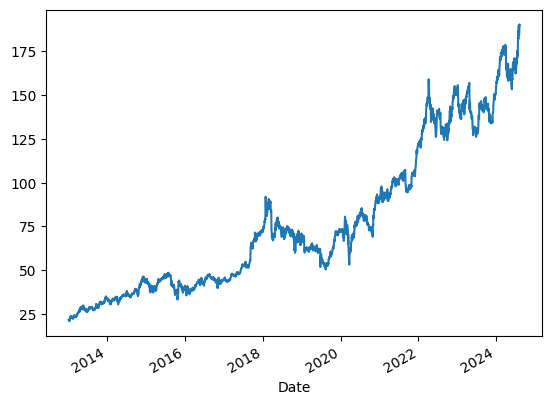

In [71]:
STOCK = "ABBV"

print(data[data['ticker'] == STOCK]['Close'].head())
data[data['ticker'] == STOCK]['Close'].plot()

In [76]:
train_data_test_data_ratio = 0.8

stock_data = data[data['ticker'] == STOCK]['Close'].values
train_data_size = int(len(stock_data) * train_data_test_data_ratio)

print(f"Stock {STOCK} has {len(stock_data)} data points")
print(f"Train data size: {train_data_size}")

train_data = stock_data[:train_data_size]
test_data = stock_data[train_data_size:]

print(f"Train test limit {stock_data[train_data_size - 5:train_data_size + 5]}")
print(f"train tail {train_data[-5:]}")
print(f"test head {test_data[:5]}")

Stock ABBV has 2921 data points
Train data size: 2336
Train test limit [148.55197144 153.53311157 157.50526428 159.03236389 154.36936951
 152.07875061 145.70779419 148.78782654 146.08361816 143.32437134]
train tail [148.55197144 153.53311157 157.50526428 159.03236389 154.36936951]
test head [152.07875061 145.70779419 148.78782654 146.08361816 143.32437134]
x train data tail [[147.15214539]
 [148.55197144]
 [153.53311157]
 [157.50526428]
 [159.03236389]]
y train data tail [[148.55197144]
 [153.53311157]
 [157.50526428]
 [159.03236389]
 [154.36936951]]
x test data head [[152.07875061]
 [145.70779419]
 [148.78782654]
 [146.08361816]
 [143.32437134]]
y test data head [[145.70779419]
 [148.78782654]
 [146.08361816]
 [143.32437134]
 [143.64518738]]
x train data shape (2335, 1)
y train data shape (2335, 1)
x test data shape (584, 1)
y test data shape (584, 1)


In [77]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_set = scaler.fit_transform(train_data.reshape(-1, 1))

scaled_training_set

array([[0.00633795],
       [0.00503442],
       [0.00305664],
       ...,
       [0.98894254],
       [1.        ],
       [0.96623606]])

In [78]:
x_train_data = train_data[:len(train_data)-1].reshape(-1, 1)
y_train_data = train_data[1:].reshape(-1, 1)

print(f"x train data tail {x_train_data[-5:]}")
print(f"y train data tail {y_train_data[-5:]}")

x_test_data = test_data[:len(test_data)-1].reshape(-1, 1)
y_test_data = test_data[1:].reshape(-1, 1)

print(f"x test data head {x_test_data[:5]}")
print(f"y test data head {y_test_data[:5]}")

print(f"x train data shape {x_train_data.shape}")
print(f"y train data shape {y_train_data.shape}")

print(f"x test data shape {x_test_data.shape}")
print(f"y test data shape {y_test_data.shape}")

x train data tail [[147.15214539]
 [148.55197144]
 [153.53311157]
 [157.50526428]
 [159.03236389]]
y train data tail [[148.55197144]
 [153.53311157]
 [157.50526428]
 [159.03236389]
 [154.36936951]]
x test data head [[152.07875061]
 [145.70779419]
 [148.78782654]
 [146.08361816]
 [143.32437134]]
y test data head [[145.70779419]
 [148.78782654]
 [146.08361816]
 [143.32437134]
 [143.64518738]]
x train data shape (2335, 1)
y train data shape (2335, 1)
x test data shape (584, 1)
y test data shape (584, 1)


In [79]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

/Users/dharma/Develop/experimental/python/trade/.env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(x_train_data, y_train_data, epochs=100, batch_size=32)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 3963.7688
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3095.5945
Epoch 3/100
57/73 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2844.8196

KeyboardInterrupt: 